<a href="https://colab.research.google.com/github/abdulmukit98/Tensorflow-in-practice-specialization/blob/master/Introduction_to_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup


In [0]:
!pip install -U tf-nightly-2.0-preview

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [0]:
def plot_series(time, series, format = "-", start = 0,
                end = None, label = None):
  plt.plot(
      time[start:end],
      series[start:end],
      format,
      label = label  
      )
  plt.xlabel("Time")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize = 14) #if there label , put legend
  plt.grid(True)

##Trend and Seasionality

In [0]:
def trend(time, slope=0):
  return slope * time      # y = mx

lets create a time series that just trends upword:

time [   0    1    2 ... 1458 1459 1460]
series [0.000e+00 1.000e-01 2.000e-01 ... 1.458e+02 1.459e+02 1.460e+02]


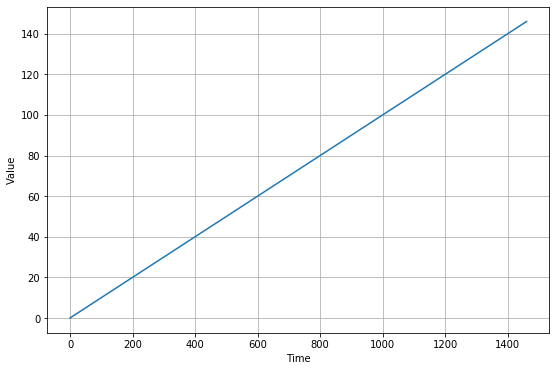

In [0]:
time = np.arange(4 * 365 +1) # num -> range
print('time',time)
series = trend( time, 0.1)   # slope = 0.1
print('series', series)

plt.figure(figsize = (9, 6))
plot_series(time, series)
plt.show()

Now lets generate a time series with seasonal pattern


In [0]:
def seasonal_pattern(season_time):
  """just an arbitary pattern"""
  return np.where(season_time<0.4, 
                  np.cos(season_time *2*np.pi),
                  1/np.exp( 3 * season_time)
                  ) # if <.4 --> cos2pi, 
                    # else  ---> 1/e^3x


def seasonality (time, period, amplitude = 1, phase = 0):
  """Repeats th same pattern each time"""
  season_time = ( (time+phase) % period ) /period    #range 0 - 1
  return amplitude * seasonal_pattern(season_time)

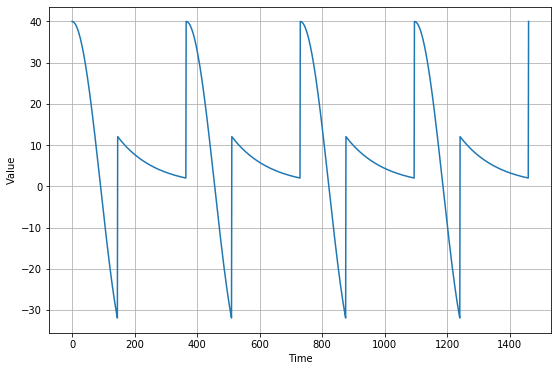

In [0]:
baseline = 10
amplitude = 40
series = seasonality(time, period=365 , amplitude = amplitude)

plt.figure(figsize=(9,6))
plot_series( time, series)
plt.show()

Now lets create a time series with both trend and seasonality

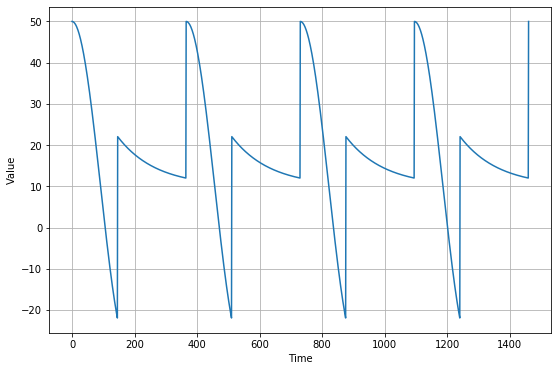

In [0]:
slope = 0.05
series = baseline + trend(time + slope) + seasonality(time, period= 365, amplitude=amplitude)

plt.figure(figsize = (9,6))
plot_series(time, series)
plt.show()

#Noise

In practice, few real world time series have such a smooth signal.
They usually have some noise, and the signal to noise ratio can sometime be very low. Lets generate some white noise

In [0]:
def white_noise(time, noise_level = 1, seed = None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level


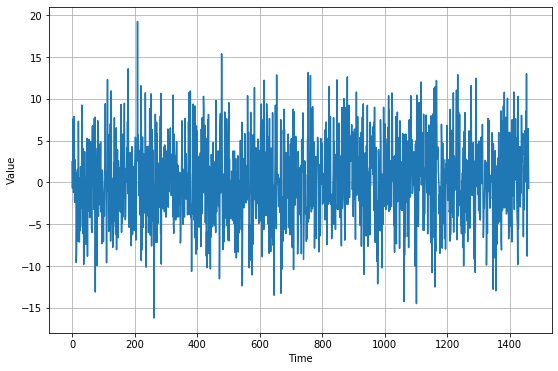

In [0]:
noise_level = 5
noise = white_noise(time, noise_level, seed = 42)

plt.figure(figsize = (9,6))
plot_series(time, noise)
plt.show()

Now lets add this noise to the time series

<function matplotlib.pyplot.show>

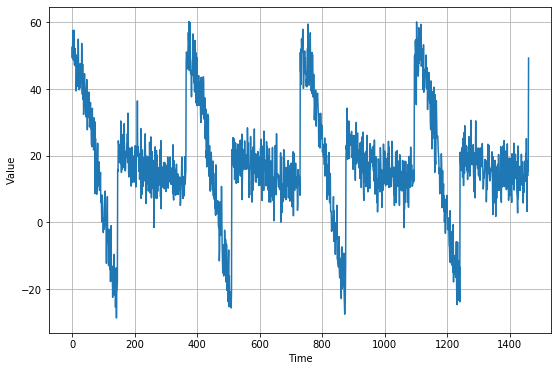

In [0]:
series += noise

plt.figure(figsize=(9,6))
plot_series(time, series)
plt.show

Alright, this look realistic for now. Lets try to forecast it. We will split it into two periods: the train period and the validation period. The split will be at time step 1000

In [0]:
split_time = 1000
time_train = time[: split_time]
x_train = series[: split_time]

time_valid = time[split_time : ]
x_valid = series[split_time : ]

In [0]:
def autocorrelation(time, amplitude, seed = None):
  rnd = np.random.RandomState(seed)
  w1 = 0.5
  w2 = -0.1
  ar = rnd.randn(len(time) + 50)
  ar[:50] = 100
  for step in range(50, len(time) + 50):
    ar[step] += w1 * ar[step - 50]
    ar[step] += w2 * ar[step - 33]
  return ar[50:] * amplitude


In [0]:
def autocorrelation(time, amplitude, seed = None):
  rnd = np.random.RandomState(seed)
  w = 0.8
  ar = rnd.randn(len(time) + 1)
  for step in range(1, len(time) + 1):
    ar[step] += w * ar[step - 1]
  return ar[1:] * amplitude

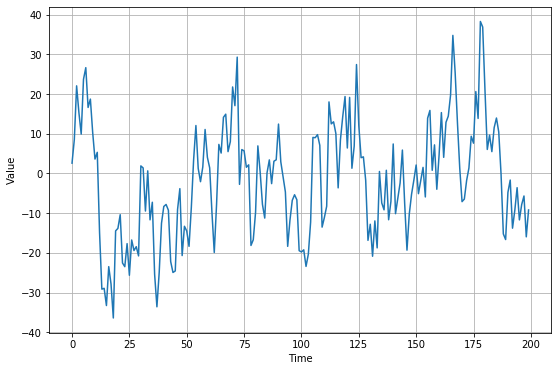

In [0]:
series = autocorrelation(time, 10, seed = 42)
plt.figure(figsize=(9,6))
plot_series(time[:200], series[:200])
plt.show()

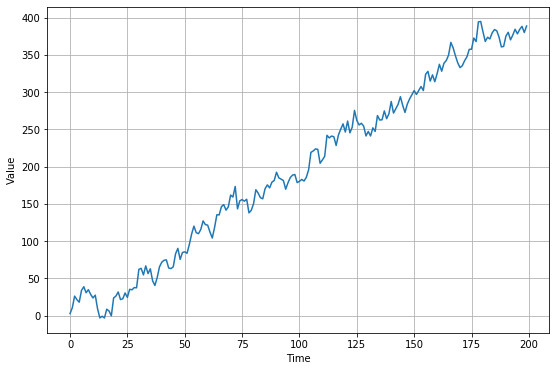

In [0]:
series = autocorrelation(time, 10, seed=42) + trend(time,2)
plt.figure(figsize=(9,6))
plot_series(time[:200], series[:200])
plt.show()

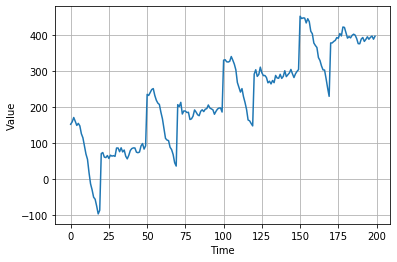

In [0]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

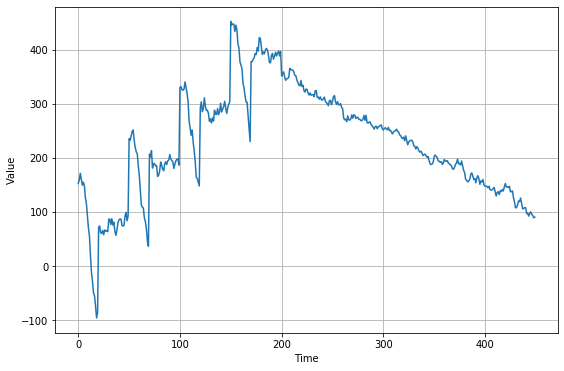

In [0]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550
#from 200, change its pattern -ve slop
series[200:] = series2[200:]

plt.figure(figsize= (9,6))
plot_series(time[:450], series[:450])

In [0]:
def impulses(time, num_impulses, amplitude=1, seed=None):
  rnd = np.random.RandomState(seed)
  impulses_indices = rnd.randint(len(time), size=10)
  series = np.zeros(len(time))
  for i in impulses_indices:
    series[i] += rnd.rand() * amplitude
  return series

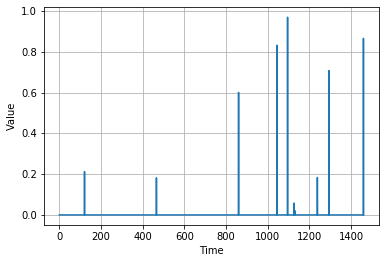

In [0]:
series = impulses(time, 10, seed=42)
plot_series(time, series)
plt.show()

In [0]:
def autocorrelation(source, ws):
  ar = source.copy()
  max_lag = len(ws)
  for step, value in enumerate(source):
    for lag, w in ws.items():
      if step - lag > 0:
        ar[step] += w * ar[step - lag]
  return ar

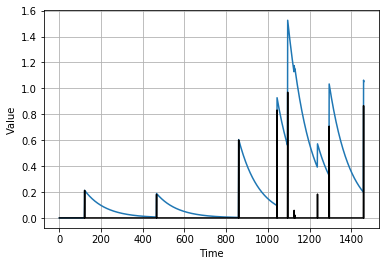

In [0]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.99})

plot_series(time, series)
plt.plot(time, signal, 'k-')
plt.show()

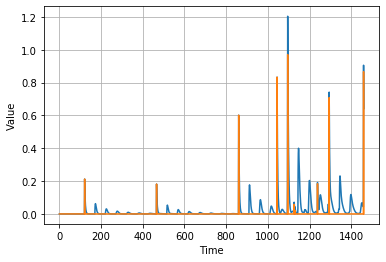

In [0]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.70, 50: 0.2})

plot_series(time, series)
plt.plot(time, signal)
plt.show()